In [1]:
import os
import sys
import ogr
from gdalconst import *
import gdal as gdal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create path to data directory, make sure it exists
data_dir = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir),"Data")
assert os.path.isdir

In [3]:
# Define paths to image file and shape files + make sure it exists
shpf = os.path.join(data_dir, "Random_Buffers.shp")
assert os.path.isfile(shpf)

# Reading Vector Data

In [4]:
# Create the Data Source
ds = ogr.Open(shpf, GA_ReadOnly)

# Check how many layers there are in the shapefile
# Most shapefiles should only have 1 layer... it 
# is "probably" safe to assume this is true 
print(ds.GetLayerCount())

# Create layer from first (only) layer in file
lyr = ds.GetLayer(0)  

1


In [5]:
# Check what geometry this shapefile contains
# Geometry Types:  1:Point, 2:Line, 3:Polygon, 4:MultiPoint, 5:MultiLineString, 6:MultiPolygon
print(lyr.GetGeomType())

# Check how many records/features are in this layer
print(lyr.GetFeatureCount())

3
15


In [6]:
# Access a single feature
feat = lyr.GetFeature(0)  #Integer provided will access the record with that FID

In [7]:
# Get Envleope from feature
feat.geometry().GetEnvelope()

(493974.4250881527, 494174.4250881527, 5024103.2308988795, 5024303.2308988795)

In [8]:
# Get geometry of feature -- figure out why this is weird
geof = feat.GetGeometryRef()
ring = geof.GetGeometryRef(0)

In [9]:
# put points in an array
circle = np.array([x for x in ring.GetPoints()])

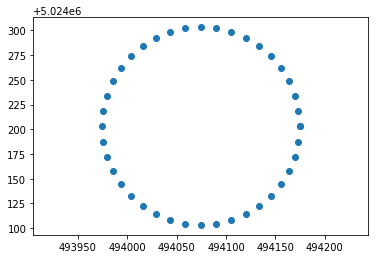

In [10]:
# Plot this shit
plt.scatter(circle[:,0], circle[:,1])
plt.axis('equal')
plt.show()

In [11]:
# Scatter plots are cool... but what if i want to use this with raster data...
# Steps are as follows
# 1. Find offset from UL of raster to UL of vector envelope
# 2. Create Memory Driver + memory layer for cloned vector feature
# 3. Clone the vector feature to the memory layer
# 4. Create a memory driver + layer for the newly rasterized polygon
# 5. Calculate geotransform for new in-memory raster feature
# 6. Use built in function to rasterize vector to in-memory raster layer

In [12]:
# Create path to data directory, make sure it exists
data_dir = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir),"Data")
assert os.path.isdir

# Define paths to image file and shape files + make sure it exists
imgf = os.path.join(data_dir, "PDX_DEM_WGS84_UTM10N_Zm_INT16.tif")
assert os.path.isfile(imgf)

# Open Raster Dataset
ds = gdal.Open(imgf, GA_ReadOnly)

In [13]:
# Get geotransform for raster
ogt = ds.GetGeoTransform()
# Unpack geotransform so we don't have to remember index labels
origin_x, pixel_width, _, origin_y, _, pixel_height = ogt

# Get Envelope from polygon
bbox = feat.geometry().GetEnvelope()

#Determine distance in x/y (respectively) from envelope UL
# Then scale by pixel size to give raster index location 
# of upper left corner of envelope
x1 = int(round((bbox[0] - origin_x) / pixel_width))
x2 = int(round((bbox[1] - origin_x) / pixel_width))

# Do the same calculation to find the LR corner of the 
# envelope in raster index coordinate
y1 = int(round((bbox[3] - origin_y) / pixel_height))
y2 = int(round((bbox[2] - origin_y) / pixel_height))

# Subtract to find width(xsize) and height(ysize)
xsize = x2 - x1
ysize = y2 - y1

# src_offset = [x1, y1, xsize, ysize]
# Print ULxy
# Print new array dimensions

In [14]:
# Create memory driver
mem_drv = ogr.GetDriverByName('Memory')

# Get the driver by
driver = gdal.GetDriverByName('MEM')

In [ ]:
# Create a blank dataset object using the memory driver
mem_ds = mem_drv.CreateDataSource('out')

# Create a blank layer object using the spatial reference of the original vector file
mem_layer = mem_ds.CreateLayer('poly', lyr.GetSpatialRef(), ogr.wkbPolygon)

# Clone the feature (selected above using the fid or a record)
mem_layer.CreateFeature(feature.Clone())

# Create a blank raster dataset object using the calculated array size from above
rvds = driver.Create('', xsize, ysize, 1, gdal.GDT_Byte)

# calculate a new geotransform for the created raster using the original geotransform,
# and the offsets calculated from the vector envelope. 
# Note: we aren't scaling the raster, so we can use the original pixel width/height values
new_ulx = origin_x + (x1 * pixel_width)
new_uly = origin_y + (y1 * pixel_height)
ngt = (new_ulx, pixel_width, 0.0, new_uly, 0.0, pixel_height)

# Set the geotransform of the blank raster dataset
rvds.SetGeoTransform(ngt)

# use gdal function to burn in values to pixels inside the vector we are trying to rasterize
### Function needs dataset, band of dataset to burn to, and the vector layer used for burning, 
### optionally you can specify the value you want burnt into the raster
gdal.RasterizeLayer(rvds, [1], mem_layer, burn_values=[1])

# Read data from newly created raster into a numpy array
rv_array = rvds.ReadAsArray()

In [16]:
# Plot just the rasterized vector
# Use indexing to plot the portion of the dem that is "underneath" the rasterized vector
# Create a blank array the size of the dem, use indexing to "insert" the rasterized vector 

In [17]:
#lyr.GetSpatialRef()

In [18]:
dir(lyr)

['AlterFieldDefn',
 'Clip',
 'CommitTransaction',
 'CreateFeature',
 'CreateField',
 'CreateFields',
 'CreateGeomField',
 'DeleteFeature',
 'DeleteField',
 'Dereference',
 'Erase',
 'FindFieldIndex',
 'GetDescription',
 'GetExtent',
 'GetFIDColumn',
 'GetFeature',
 'GetFeatureCount',
 'GetFeaturesRead',
 'GetGeomType',
 'GetGeometryColumn',
 'GetLayerDefn',
 'GetMetadata',
 'GetMetadataDomainList',
 'GetMetadataItem',
 'GetMetadata_Dict',
 'GetMetadata_List',
 'GetName',
 'GetNextFeature',
 'GetRefCount',
 'GetSpatialFilter',
 'GetSpatialRef',
 'GetStyleTable',
 'Identity',
 'Intersection',
 'Reference',
 'ReorderField',
 'ReorderFields',
 'ResetReading',
 'RollbackTransaction',
 'SetAttributeFilter',
 'SetDescription',
 'SetFeature',
 'SetIgnoredFields',
 'SetMetadata',
 'SetMetadataItem',
 'SetNextByIndex',
 'SetSpatialFilter',
 'SetSpatialFilterRect',
 'SetStyleTable',
 'StartTransaction',
 'SymDifference',
 'SyncToDisk',
 'TestCapability',
 'Union',
 'Update',
 '__bool__',
 '__clas